# Deconvolution under Gaussian prior

We use an Expectation-Maximization framework in order to apply the $MAP_k$ algorithm with a Gaussian prior.

[_Efficient Marginal Likelihood Optimization in Blind Deconvolution_, Levin _et al._, 2011]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from PIL import Image
from IPython.display import display, clear_output

In [2]:
n = 256 # Image size is n*n
N = n**2 # Pixels per image
K = 7 # Kernel size is (2K+1)*(2K+1)
KK = (2*K+1)**2
# (note that when performing convolution, we consider the image to be its own symmetric past the edges,
# with the boundary pixels taking up two spaces)

eta = 0.01
sigma = 0.3

## EM algorithm

Alternate between two steps : estimating the likely image (and its covariance), and estimating the likely kernel.

### E-step
Set $$q(x) = p(x \mid y,k),$$
and compute its mean $\mu$ and covariance $C$ (i.e. estimate the likely image, but also look at how much it could vary).

Under a Gaussian prior, $\mu$ and $C$ can be expressed simply in terms of $A_x$ and $b_x$:
$$ A_x = \frac{1}{\eta^2}T_k^t T_k + \frac{1}{\sigma^2}(T_{f_v}^t T_{f_v} + T_{f_h}^t T_{f_h})$$
$$ b_x = \frac{1}{\eta^2} T_k^t y $$
Here $T_k$, $T_{f_h}$ and $T_{f_v}$ are the convolution operators (almost Toeplitz matrices, but with 2D-indices).

The conditional distribution $q$ is in fact Gaussian as well, and we can simply express its features given $A_x$ and $b_x$:
$$ C = A_x^{-1} $$
$$ \mu = C b_x $$

In [3]:
def image_index(i,j):
    return (i%n)*n + (j%n)

image_index_ = np.array([[image_index(i,j) for j in range(2*n)] for i in range(2*n)])

def kernel_index(u,v):
    return ((u+K)%(2*K+1))*(2*K+1) + (v+K)%(2*K+1)

def kernel_coords(k_index):
    u = k_index // (2*K+1) - K
    v = k_index % (2*K+1) - K
    assert kernel_index(u,v) == k_index
    return u,v

Compute the frequency representation of the Toeplitz matrices.

Construct the matrices $F$ and `F1`$=F^{-1}$, for the basis change from pixel basis to Fourier basis and back.

In this new basis, $A_x$ is diagonal:
$$F A_x F^{-1} = diag \left( \frac{1}{\eta^2} |Fk|^2 + \frac{1}{\sigma^2}\left(|F f_h|^2 + |F f_v|^2 \right) \right)$$

In [4]:
import numpy.fft as fft

def fourier(img):
    return np.reshape(fft.fft2(np.reshape(img,(n,n))),N)

def ifourier(img):
    return np.reshape(fft.ifft2(np.reshape(img,(n,n))),N)

In [5]:
# Precompute Ff1_sq and Ff2_sq, which are used later
f1_image = np.zeros(N); f1_image[0] = -1; f1_image[1] = 1
f2_image = np.zeros(N); f2_image[0] = -1; f2_image[n] = 1
Ff1_sq = abs(fourier(f1_image))**2
Ff2_sq = abs(fourier(f2_image))**2


def pad_kernel(kernel):
    kernel = np.reshape(kernel,(2*K+1,2*K+1))
    newk = np.zeros((n,n))
    newk[:K+1,:K+1] = kernel[K:,K:]
    newk[-K:,:K+1] = kernel[:K,K:]
    newk[:K+1,-K:] = kernel[K:,:K]
    newk[-K:,-K:] = kernel[:K,:K]
    return np.reshape(newk,N)


def compute_mu_and_C(kernel,y,eta=eta,sigma=sigma):
    kernel = pad_kernel(kernel)
    # Diagonal factors of A_x in Fourier basis
    kernel_fourier = fourier(kernel)
    A_x_fourier = 1/eta**2 * abs(kernel_fourier)**2 + 1/sigma**2 * (Ff1_sq+Ff2_sq)
    C_fourier = 1/A_x_fourier
    C_row = np.abs(ifourier(C_fourier)) # Values of the sum used in M-step. That's all we need.
    Fy = fourier(y)
    mu = 1/eta**2 * np.real(ifourier(Fy*np.conj(kernel_fourier)*C_fourier))
    return mu,C_row

In [6]:
def convolve(img,kernel):
    kernel = pad_kernel(kernel)
    return np.real(ifourier(fourier(img) * fourier(kernel)))

#### Deconvolution test
Create an artificial  image, and perform non-blind deconvolution on it with the ground truth kernel.

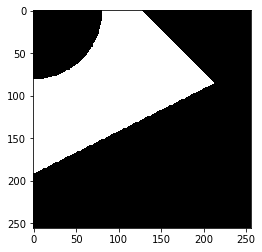

In [7]:
xx,yy = np.meshgrid(np.arange(n),np.arange(n))
img = (xx+2*yy < 1.5*n) & (xx-yy < 0.5*n) & (xx**2+yy**2 > 0.1*n**2)
plt.imshow(img,cmap='gray')
plt.show()

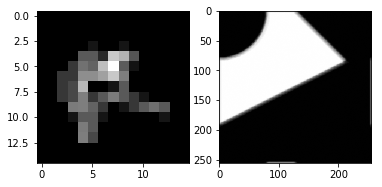

In [8]:
kxx,kyy = np.meshgrid(np.arange(-K,K+1),np.arange(-K,K+1))
#kernel = np.exp(-0.01*kxx**2-0.03*kyy**2) + np.exp(-0.1*(kxx-3)**2 - (kyy-1)**2)
kernel = Image.open('kernel1.png')
kernel /= np.sum(kernel,axis=None)
plt.subplot(1,2,1)
plt.imshow(kernel,cmap='gray')

img_blurred = np.reshape(convolve(img,kernel),(n,n))
img_blurred += np.random.randn(n,n)*0.1*eta # Add noise

plt.subplot(1,2,2)
plt.imshow(img_blurred,cmap='gray')
plt.show()

y = np.reshape(img_blurred,N)

Wall time: 19 ms


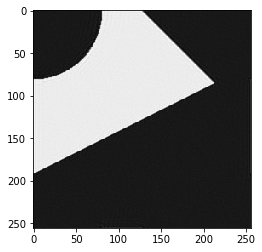

In [9]:
%time mu,C = compute_mu_and_C(np.reshape(kernel,KK),np.reshape(img_blurred,N))
plt.imshow(np.reshape(mu,(n,n)),cmap='gray')
plt.show()

### M-step
Estimate the kernel $k$ minimizing
$$ E_q \left[  || k*x - y ||^2  \right] .$$
Since we are considering the $q$-expectation of something quadratic, it only depends on the first two moments of $q(x)$, so $\mu$ and $C$ are sufficient.

The kernel $k$ is the solution to the quadratic programming problem
$$ \min_k \frac{1}{2} k^t \bar{A_k} k - \bar{b_k} k \quad s.t.\; k\ge 0,$$
where
$$ \bar{A_k}_{(i_1,j_1),(i_2,j_2)} = \sum_{i,j} \mu_{(i+i1,j+j1)} \mu_{(i+i2,j+j2)} + C_{(i+i1,j+j1),(i+i2,j+j2)}$$
and
$$ \bar{b_k}_{(i1,j1)} = \sum_{i,j} \mu_{(i+i1,j+j1)} y_{(i,j)} $$
are mean values of respectively the covariance of $m \times m$ windows in $x$, and the correlation of $x$ and $y$.

Matrix $\bar{A_k}$ is actually a Toeplitz matrix, as $\bar{A_k}_{(i1,j1),(i2,j2)}$ only depends on $(i1-i2,j1-j2)$.

In [10]:
def compute_kernel(mu,C,y,eta=eta,sigma=sigma):
    print("Computing A_k & b_k")
    A_k_values = np.zeros((4*K+1,4*K+1)) # Compute A_k(i+i1,i)
    b_k = np.zeros((2*K+1,2*K+1))
    mu2d = np.reshape(mu,(n,n))
    
    i__ =  np.array([image_index_[i,j] for i in range(n) for j in range(n)])
    
    for i1 in range(-2*K,2*K+1):
        for j1 in range(-2*K,2*K+1):
            mu_shift_2d = np.roll(mu2d,i1,0)
            mu_shift_2d = np.roll(mu_shift_2d,j1,1)
            mu_shift = np.reshape(mu_shift_2d,N)
            i_plus_i1 = np.array([image_index_[i+i1,j+j1] for i in range(n) for j in range(n)])
            A_k_values[i1+2*K,j1+2*K] = np.sum(mu * mu_shift) + C[image_index(i1,j1)]
            if -K<=i1<=K and -K<=j1<=K:
                b_k[i1+K,j1+K] = np.sum(mu_shift * y)
    b_k = np.reshape(b_k,KK)
    print("Wrapping up A_k")
    A_k = np.zeros((KK,KK))
    for i1j1 in range(KK):
        i1,j1 = kernel_coords(i1j1)
        for i2j2 in range(KK):
            i2,j2 = kernel_coords(i2j2)
            A_k[i1j1,i2j2] = A_k_values[i1-i2+2*K, j1-j2+2*K]
    #print('A_k =',A_k)
    #print('b_k =',b_k)
    signed_solution = np.linalg.inv(A_k).dot(b_k)
    #print('A_k-1 b_k',signed_solution)
    
    
    print("Solving quadratic minimization problem")
    def fun(k):
        Akk = A_k.dot(k)
        return 0.5*np.transpose(k).dot(Akk) - b_k.dot(k), Akk-b_k
    
    opt_result = opt.minimize(fun,signed_solution,jac=True,bounds=[(0,None) for _ in range(KK)])
    new_kernel = opt_result.x
    return new_kernel

In [11]:
%time new_kernel = compute_kernel(mu,C,y)
#print(new_kernel)

Computing A_k & b_k
Wrapping up A_k
Solving quadratic minimization problem
Wall time: 14.9 s


In [12]:
my_array = np.ones((10,15))
my_indices = np.array([(0,0),(1,5),(9,2)])

In [13]:
def show_img(mu):
    mu = np.maximum(0,mu)
    mu = np.minimum(256,mu)
    mu = np.reshape(mu,(n,n))
    plt.figimage(mu,cmap='gray')
    plt.axis('off')
    plt.show()

def EM_algorithm(img,iterations=30,compute_mu_and_C=compute_mu_and_C,compute_kernel=compute_kernel):
    y = np.reshape(img,N)
    #kernel = np.zeros(KK); kernel[kernel_index(0,0)] = 1; # No blur explanation
    # kernel = np.random.random(KK); kernel /= np.sum(kernel) # Very bad option
    kxx,kyy = np.meshgrid(np.arange(-K,K+1),np.arange(-K,K+1))
    kernel = np.exp(-(kxx**2+kyy**2)/3) * np.random.random(np.shape(kxx)); kernel /= np.sum(kernel)
    print('Starting with random initial kernel')
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1); plt.imshow(np.reshape(img,(n,n)),cmap='gray');
    plt.subplot(1,2,2); plt.imshow(np.reshape(kernel,(2*K+1,2*K+1)),cmap='gray')
    plt.show()
    cur_eta = 1
    for it in range(iterations):
        print("Iteration #%d" % it)
        print('current eta = %f' % cur_eta)
        mu,C = compute_mu_and_C(kernel,y,eta=cur_eta,sigma=sigma)
        kernel = compute_kernel(mu,C,y,eta=cur_eta,sigma=sigma)
        clear_output()
        show_img(mu)
        plt.imshow(np.reshape(kernel,(2*K+1,2*K+1)),cmap='gray')
        plt.colorbar(); plt.show()
        if cur_eta > eta:
            cur_eta *= 0.7
    return mu,kernel

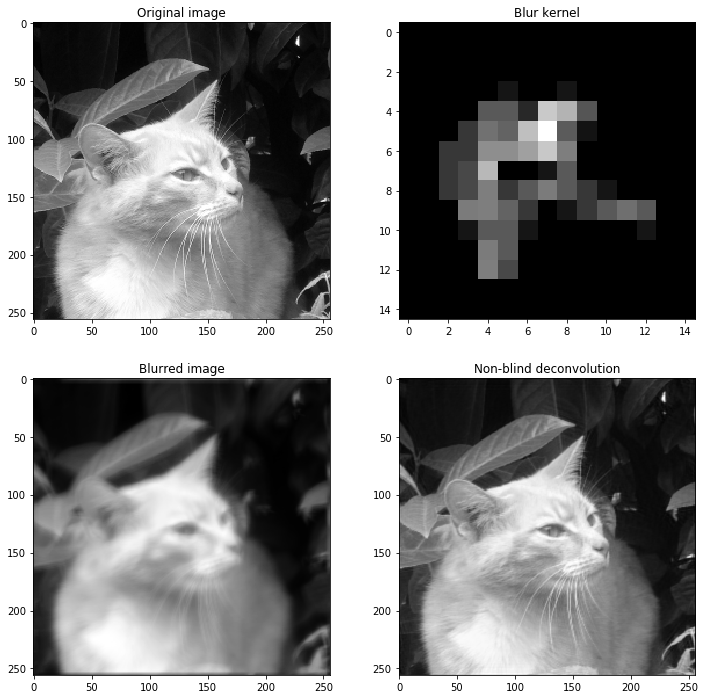

In [14]:
img = np.array(Image.open('louxor_256_gray.png'))
kernel = Image.open('kernel1.png')
kernel /= np.sum(kernel,axis=None)
img_blurred = convolve(img, kernel)
nonblind_deconv,_ = compute_mu_and_C(kernel,img_blurred)


plt.figure(figsize=(12,12))
plt.subplot(2,2,1); plt.imshow(img,cmap='gray'); plt.gca().set_title('Original image');
plt.subplot(2,2,2); plt.imshow(kernel,cmap='gray'); plt.gca().set_title('Blur kernel')
plt.subplot(2,2,3); plt.imshow(np.reshape(img_blurred,(n,n)),cmap='gray'); plt.gca().set_title('Blurred image')
plt.subplot(2,2,4); plt.imshow(np.reshape(nonblind_deconv,(n,n)),cmap='gray'); plt.gca().set_title('Non-blind deconvolution')
plt.show()

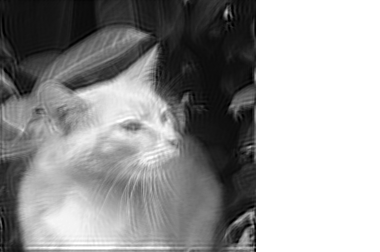

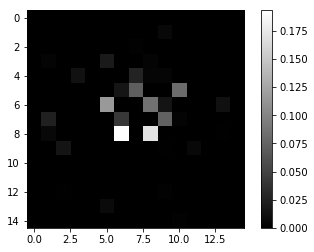

In [15]:
mu,kernel = EM_algorithm(img_blurred)

## Regularizing the kernel

It seems that we should add a regularity property on the kernel, as it seems to become very irregular in our tests.
We therefore add a Gaussian prior, which changes the probability $p(k)$ to be proportional to $exp\left(-\frac{1}{2\sigma_k^2} ||\nabla k||^2  \right)$.

This modifies the M-step. We are now trying to minimize
$$ E_q \left[  \frac{|| k*x - y ||^2}{2\eta^2}  +   \frac{||\nabla k||^2}{2\sigma_k^2} \right] .$$

The new formula for `A_k` is
$$ \bar{A_k}_{(i_1,j_1),(i_2,j_2)} = \sum_{i,j} \mu_{(i+i1,j+j1)} \mu_{(i+i2,j+j2)} + C_{(i+i1,j+j1),(i+i2,j+j2)} + \frac{\eta^2}{\sigma_k^2} (T_{f_v}^t T_{f_v} + T_{f_h}^t T_{f_h})   , $$
with a new term at the end which corresponds to our kernel regularity prior.

In [ ]:
sigma_k = 0.001*np.sqrt(KK/N) # The smaller sigma_k, the stronger the regularity
print(sigma_k)

In [529]:
Tf1 = np.zeros((KK,KK))
Tf2 = np.zeros((KK,KK))
for i in range(-K,K+1):
    for j in range(-K,K+1):
        Tf1[kernel_index(i,j),kernel_index(i,j)] = -1
        Tf1[kernel_index(i,j),kernel_index(i+1,j)] = 1
        Tf2[kernel_index(i,j),kernel_index(i,j)] = -1
        Tf2[kernel_index(i,j),kernel_index(i,j+1)] = 1
Tf1_sq = np.transpose(Tf1).dot(Tf1)
Tf2_sq = np.transpose(Tf2).dot(Tf2)
Laplace_K = Tf1_sq + Tf2_sq
print(Laplace_K) # Laplacian operator

[[ 4. -1.  0. ...,  0.  0.  0.]
 [-1.  4. -1. ...,  0.  0.  0.]
 [ 0. -1.  4. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  4. -1.  0.]
 [ 0.  0.  0. ..., -1.  4. -1.]
 [ 0.  0.  0. ...,  0. -1.  4.]]


In [530]:
def compute_kernel_regularized(mu,C,y):
    print("Computing A_k & b_k")
    A_k_values = np.zeros((4*K+1,4*K+1))
    b_k = np.zeros((2*K+1,2*K+1))
    mu2d = np.reshape(mu,(n,n))
    
    i__ =  np.array([image_index_[i,j] for i in range(n) for j in range(n)])
    
    for i1 in range(-2*K,2*K+1):
        for j1 in range(-2*K,2*K+1):
            mu_shift_2d = np.roll(mu2d,i1,0)
            mu_shift_2d = np.roll(mu_shift_2d,j1,1)
            mu_shift = np.reshape(mu_shift_2d,N)
            i_plus_i1 = np.array([image_index_[i+i1,j+j1] for i in range(n) for j in range(n)])
            A_k_values[i1+2*K,j1+2*K] = np.sum(mu * mu_shift) + C[image_index(i1,j1)]
            if -K<=i1<=K and -K<=j1<=K:
                b_k[i1+K,j1+K] = np.sum(mu_shift * y)
    b_k = np.reshape(b_k,KK)
    print("Wrapping up A_k")
    A_k = np.zeros((KK,KK))
    for i1j1 in range(KK):
        i1,j1 = kernel_coords(i1j1)
        for i2j2 in range(KK):
            i2,j2 = kernel_coords(i2j2)
            A_k[i1j1,i2j2] = A_k_values[i1-i2+2*K, j1-j2+2*K]
    print('A_k =',A_k)
    print('b_k =',b_k)
    A_k += (eta/sigma_k)**2 * Laplace_K
    signed_solution = np.linalg.inv(A_k).dot(b_k)
    #print('A_k-1 b_k',signed_solution)
    
    
    print("Solving quadratic minimization problem")
    def fun(k):
        Akk = A_k.dot(k)
        return 0.5*np.transpose(k).dot(Akk) - b_k.dot(k), Akk-b_k
    
    opt_result = opt.minimize(fun,signed_solution,jac=True,bounds=[(0,None) for _ in range(KK)])
    new_kernel = opt_result.x

    return new_kernel

Apply the algorithm with the new formula

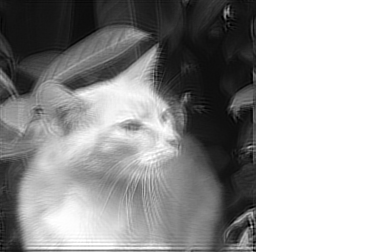

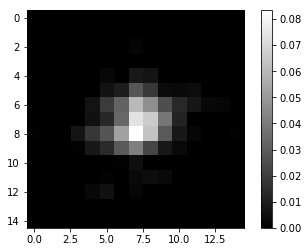

Iteration #5
Computing A_k & b_k


KeyboardInterrupt: 

In [531]:
mu,kernel = EM_algorithm(img_blurred,compute_kernel=compute_kernel_regularized)